In [1]:
%config Completer.use_jedi = False
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as f

In [3]:
spark = SparkSession.builder.config('spark.shuffle.file.buffer','1m')\
    .config('spark.sql.adaptive.enabled','true')\
    .getOrCreate()

In [4]:
train_df = spark.read.csv('train.csv', header=True, inferSchema=True)
test_df = spark.read.csv('test.csv', header=True, inferSchema=True)

pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

# Profile and Describe Data
## Summarize and get shape

In [5]:
train_df.show(5)

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| null|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| null|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| null|       S|
+-----------+--------+------+--------------------+------+----+-----+-----+------

In [6]:
train_df.dtypes

[('PassengerId', 'int'),
 ('Survived', 'int'),
 ('Pclass', 'int'),
 ('Name', 'string'),
 ('Sex', 'string'),
 ('Age', 'double'),
 ('SibSp', 'int'),
 ('Parch', 'int'),
 ('Ticket', 'string'),
 ('Fare', 'double'),
 ('Cabin', 'string'),
 ('Embarked', 'string')]

In [7]:
train_df.describe().show()

+-------+-----------------+-------------------+------------------+--------------------+------+------------------+------------------+-------------------+------------------+-----------------+-----+--------+
|summary|      PassengerId|           Survived|            Pclass|                Name|   Sex|               Age|             SibSp|              Parch|            Ticket|             Fare|Cabin|Embarked|
+-------+-----------------+-------------------+------------------+--------------------+------+------------------+------------------+-------------------+------------------+-----------------+-----+--------+
|  count|              891|                891|               891|                 891|   891|               714|               891|                891|               891|              891|  204|     889|
|   mean|            446.0| 0.3838383838383838| 2.308641975308642|                null|  null| 29.69911764705882|0.5230078563411896|0.38159371492704824|260318.54916792738| 32.20420

### Check for # of unique vals

In [8]:
train_df.select('survived').distinct().show()

+--------+
|survived|
+--------+
|       1|
|       0|
+--------+



In [9]:
{c: train_df.select(c).distinct().count() for c in train_df.columns}

{'PassengerId': 891,
 'Survived': 2,
 'Pclass': 3,
 'Name': 891,
 'Sex': 2,
 'Age': 89,
 'SibSp': 7,
 'Parch': 7,
 'Ticket': 681,
 'Fare': 248,
 'Cabin': 148,
 'Embarked': 4}

In [10]:
# {c: train_df.select(c).distinct().show() for c in train_df.columns}

In [11]:
### Get Nulls
print('# of Nulls:')
{c: train_df.select(c).where(f.col(c).isNull()).count() for c in train_df.columns}

# of Nulls:


{'PassengerId': 0,
 'Survived': 0,
 'Pclass': 0,
 'Name': 0,
 'Sex': 0,
 'Age': 177,
 'SibSp': 0,
 'Parch': 0,
 'Ticket': 0,
 'Fare': 0,
 'Cabin': 687,
 'Embarked': 2}

# Process Data

## Remove Duplicates

In [12]:
dt_df = train_df.distinct()
dte_df = test_df.distinct()

## Fill na

In [13]:
print("# of Nulls in Age:")
print(dt_df.select('Age').filter('Age IS NULL').count())
# dt_df.select('Age').where(f.col('Age').isNull()).show()
# dt_df.select('Age').where(dt_df['Age'].isNull()).show()

# of Nulls in Age:
177


In [14]:
### Get Median Age
med_age = dt_df.approxQuantile('Age',[0.5],0)[0]
# ave_age = dt_df.groupBy().agg({'Age': 'mean'})
ave_age = dt_df.groupby().mean('Age').first()[0]
# ave_age = dt_df.select(f.mean('Age'))
med_dte_age = dte_df.approxQuantile('Age',[0.5],0)[0]

print(med_age,ave_age)

28.0 29.69911764705882


In [15]:
dt_df = dt_df.withColumn('ageImputed', f.when(f.col('Age').isNull(),'1').otherwise(0))
dte_df = dte_df.withColumn('ageImputed', f.when(f.col('Age').isNull(),'1').otherwise(0))

In [16]:
dt_df_nna = dt_df.na.fill(med_age, subset='Age')
dte_df_nna = dte_df.na.fill(med_dte_age, subset='Age')

In [17]:
# dt_df_nna.select('*').filter('Age IS NULL').show()
# dt_df_nna.select('*').filter(f.expr('Age IS NULL')).show()
dt_df_nna.select('*').filter(f.col('Age').isNull()).show()
dt_df_nna.select('*').show()
dt_df.select('*').show()

+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+----------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|ageImputed|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+----------+
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+----------+

+-----------+--------+------+--------------------+------+----+-----+-----+------------------+-------+-------+--------+----------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|            Ticket|   Fare|  Cabin|Embarked|ageImputed|
+-----------+--------+------+--------------------+------+----+-----+-----+------------------+-------+-------+--------+----------+
|        612|       0|     3|Jardin, Mr. Jose ...|  male|28.0|    0|    0|SOTON/O.Q. 3101305|   7.05|   null|       S|         1|
|        666|       0|     2|  Hickman, Mr. Lewis|  male|32.0|    2|    0|      S.O.C. 14879|   73.5|   nul

In [18]:
### Impute source, dest
# dt_df_nna.groupby('embarked').max().show() # Show's max for each group among all columns
# dt_df_nna.groupby('embarked').count().agg({'embarked':'max'}).first()[0]
comm_embark = dt_df_nna.groupby('embarked').count().agg({'embarked':'max'}).select('*').first()[0][0]
dte_comm_embark = dt_df_nna.groupby('embarked').count().agg({'embarked':'max'}).select('*').first()[0][0]

dt_df_nna = dt_df_nna.withColumn('embarkedImputed', f.when(dt_df_nna['embarked'].isNull(), 1).otherwise(0))
dt_df_nnae = dt_df_nna.na.fill(comm_embark) 


dte_df_nna = dte_df_nna.withColumn('embarkedImputed', f.when(dte_df_nna['embarked'].isNull(), 1).otherwise(0))
dte_df_nnae = dte_df_nna.na.fill(dte_comm_embark) 


dt_df_nnae.where(f.col('embarkedImputed') == 1).show()

+-----------+--------+------+--------------------+------+----+-----+-----+------+----+-----+--------+----------+---------------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|ageImputed|embarkedImputed|
+-----------+--------+------+--------------------+------+----+-----+-----+------+----+-----+--------+----------+---------------+
|         62|       1|     1| Icard, Miss. Amelie|female|38.0|    0|    0|113572|80.0|  B28|       S|         0|              1|
|        830|       1|     1|Stone, Mrs. Georg...|female|62.0|    0|    0|113572|80.0|  B28|       S|         0|              1|
+-----------+--------+------+--------------------+------+----+-----+-----+------+----+-----+--------+----------+---------------+



# Visualize Data

In [19]:
pd_df = dt_df_nnae.toPandas()

PassengerId           AxesSubplot(0.125,0.536818;0.168478x0.343182)
Survived           AxesSubplot(0.327174,0.536818;0.168478x0.343182)
Pclass             AxesSubplot(0.529348,0.536818;0.168478x0.343182)
Age                AxesSubplot(0.731522,0.536818;0.168478x0.343182)
SibSp                    AxesSubplot(0.125,0.125;0.168478x0.343182)
Parch                 AxesSubplot(0.327174,0.125;0.168478x0.343182)
Fare                  AxesSubplot(0.529348,0.125;0.168478x0.343182)
embarkedImputed       AxesSubplot(0.731522,0.125;0.168478x0.343182)
dtype: object

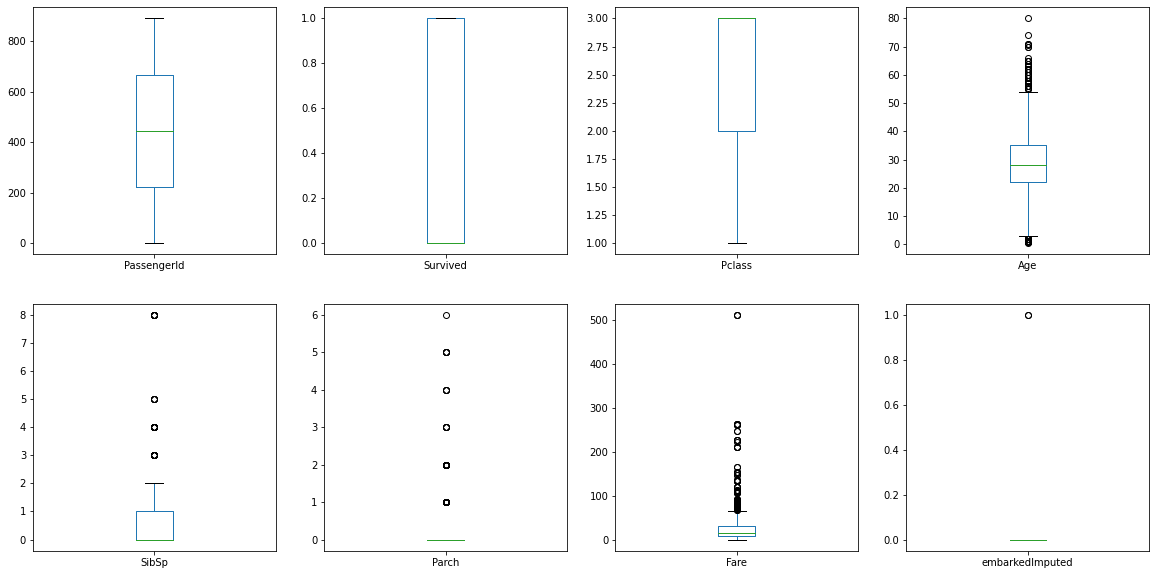

In [20]:
pd_df.plot(kind='box',subplots=True, sharex=False, sharey=False, layout=(2,4), figsize=(20,10))

/opt/venv/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


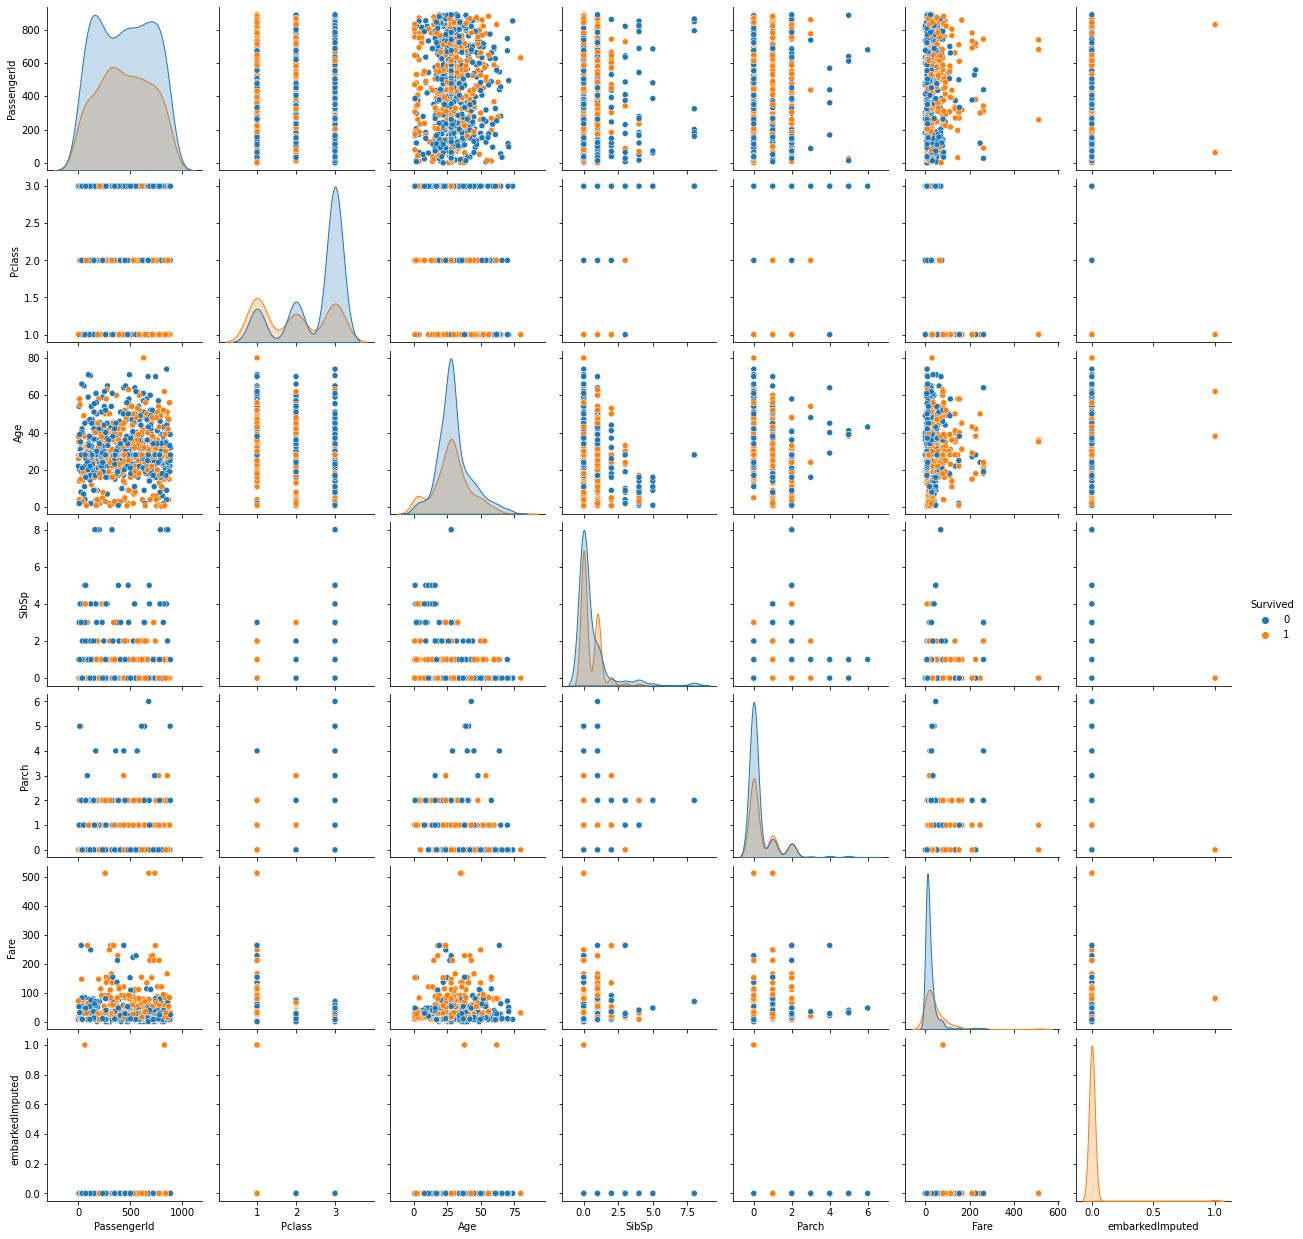

In [21]:
sns.pairplot(pd_df, hue='Survived')

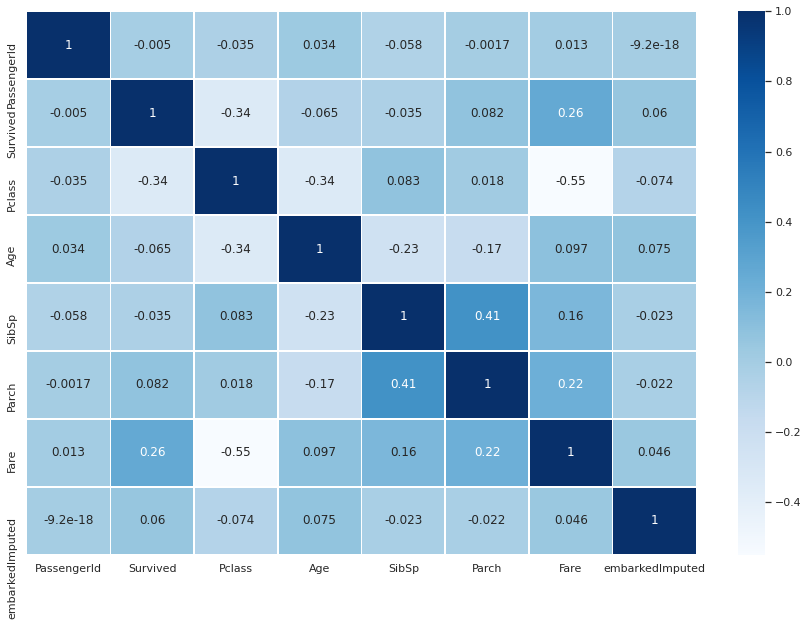

In [22]:
sns.set(style="white") 
plt.rcParams['figure.figsize'] = (15, 10) 
sns.heatmap(pd_df.corr(), annot = True, linewidths=.5, cmap="Blues")
plt.show()

### Build ML Pipeline

In [23]:
final_df = dt_df_nnae.select("Pclass", "Sex", "Age", "SibSp", 'Parch', 'Fare', 'Embarked', "Survived")
train_df, test_df = final_df.randomSplit([.80,.20],seed=42)

### Index Strings

In [24]:
from pyspark.ml.feature import StringIndexer

In [25]:
sindexer=StringIndexer(inputCols=["Sex","Embarked"], outputCols=['SexIndexed','EmbarkedIndexed'])

In [26]:
# sindexer_model = sindexer.fit(train_df)
# sml_df = sindexer_model.transform(train_df)

### OHE

In [27]:
from pyspark.ml.feature import OneHotEncoder

In [28]:
ohe = OneHotEncoder(inputCols=['SexIndexed','EmbarkedIndexed','Pclass'], outputCols=['SexOHE','EmbarkedOHE','PclassOHE'])

In [29]:
# ohe_model = ohe.fit(sml_df)
# osml_df = ohe_model.transform(sml_df)

### Assemble features into a vector

In [30]:
from pyspark.ml.feature import VectorAssembler

In [31]:
vecAssembler = VectorAssembler(inputCols=['Age','Fare','SexOHE','EmbarkedOHE','PclassOHE'], outputCol='features')
# vecAssembler = VectorAssembler(inputCols=['Age','Fare','SexIndexed','SexIndexed','SexIndexed'], outputCol='features')

In [32]:
# vosml_df = vecAssembler.transform(osml_df)
# vosml_df = vecAssembler.transform(sml_df)

### Model

In [33]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.classification import NaiveBayes

In [34]:
# rf_classifier = RandomForestClassifier(featuresCol='features',labelCol='Survived', seed=42)
# linsvcModel = LinearSVC(featuresCol='features',labelCol='Survived')
# lregModel = LogisticRegression(featuresCol='features',labelCol='Survived')
gbtModel = GBTClassifier(featuresCol='features',labelCol='Survived')
# bayesModel = NaiveBayes(featuresCol='features',labelCol='Survived')

### Create Param Grid for xvalidation for hyperparameter tuning

In [35]:
from pyspark.ml.tuning import ParamGridBuilder

In [36]:
# pgb_gbt = ParamGridBuilder().addGrid(gbtModel.maxDepth, [2,4]).addGrid(gbtModel.maxBins, [32]).build()

### Create Pipeline

In [37]:
from pyspark.ml import Pipeline
# pipeline = Pipeline(stages=[sindexer_model, ohe_model, vecAssembler,rf_classifier]) # 81%
# pipeline = Pipeline(stages=[sindexer_model, vecAssembler,rf_classifier])

# pipeline = Pipeline(stages=[sindexer_model, ohe_model, vecAssembler,linsvcModel]) # LinearSVC 75

# pipeline = Pipeline(stages=[sindexer_model, ohe_model, vecAssembler,lregModel]) # lregModel 75,76

pipeline = Pipeline(stages=[sindexer_model, ohe_model, vecAssembler,gbtModel]) # gbtModel 81,81
# pipeline = Pipeline(stages=[sindexer_model, vecAssembler,gbtModel]) # gbtModel 74
# pipeline = Pipeline(stages=[sindexer_model, ohe_model, vecAssembler,gbtModel]) # gbtModel 81,81
# pipeline = Pipeline(stages=[sindexer, ohe, vecAssembler,gbtModel]) # gbtModel 81,81

# pipeline = Pipeline(stages=[sindexer_model, ohe_model, vecAssembler,mpcModel]) # ?

# pipeline = Pipeline(stages=[sindexer_model, ohe_model, vecAssembler,bayesModel]) # 66, 66

# pipeline = Pipeline(stages=[sindexer_model, ohe_model, vecAssembler,mccModel]) # ?

pipelineModel = pipeline.fit(train_df)

rf_predictions = pipelineModel.transform(test_df)

NameError: name 'sindexer_model' is not defined

### Evaluate Model

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [ ]:
mcc_eval = MulticlassClassificationEvaluator(labelCol='Survived',metricName='accuracy')

In [ ]:
print('Accuracy: ', mcc_eval.evaluate(rf_predictions))

In [ ]:
mcc_eval_prec = MulticlassClassificationEvaluator(labelCol='Survived',metricName='weightedPrecision')

In [ ]:
# print('Precision: ', mcc_eval_prec.evaluate(rf_predictions))

### Create xvalidator

In [ ]:
from pyspark.ml.tuning import CrossValidator

In [ ]:
cv = CrossValidator(estimator=pipeline, evaluator=mcc_eval, estimatorParamMaps=pgb_gbt, numFolds=1, seed=42)

In [ ]:
cvModel = cv.fit(train_df)

### How important was each feature?

In [ ]:
list(zip(vecAssembler.getInputCols(), pipelineModel.stages[-1].featureImportances))

In [ ]:
cv.getEstimatorParamMaps, cv.